# VetsinTech Project - Stock Price Forecast (up or down)
### AI/ML Capstone for VetsinTech with Michael Galarnyk

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project I will try to determine the probability of Apple stock being either up or down the following day. Determination of price being up or down is of more use to us vs. an absolute price. I will be using a Random Forrest Classifier for this due to its robustness and accuracy. It fits well with classifying the stock price as up or down.

## Data <a name="data"></a>

Following data sources will be needed to extract/generate the required information:
* The stock price and earnings will come from **AlphaVantage** -https://www.alphavantage.co/.
* The Apple stock earnings quarterly data also includes analyst estimates and surprise metrics which may or may not prove useful.

## Import Dependencies

In [42]:
# Data Processing
import pandas as pd  # library for data analsysis
import numpy as np  # library to handle data in a vectorized manner
#import pyarrow
import mplfinance as mpf # matplotlib utilities for the visualization, and visual analysis, of financial data
import requests # library to handle requests
import json # library to handle JSON files

# Modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import roc_auc_score, roc_curve
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from xgboost import plot_importance
import joblib

# Visualization
from IPython.display import display
import matplotlib.pyplot as plt 
import seaborn as sns
#from sklearn.tree import export_graphviz
from IPython.display import Image
#import graphviz

print('Libraries imported.')

Libraries imported.


## Analysis <a name="Analysis"></a>

## Get earnings history

The **reportedEPS** is the actual Earings Per Share (EPS) as reported by Apple. The **estimatedEPS** are aggregated EPS from analysts. **Surprise** column is the difference between the two, and **suprisePercentage** is the percentage difference.

In [2]:
#Earnings from Alphvantage
df = pd.read_csv('earnings.csv', index_col='reportedDate', parse_dates=True)
df

,reportedEPS,estimatedEPS,surprise,surprisePercentage
reportedDate,,,,
2024-02-01,2.0200,1.93,0.0900,4.6632
2023-11-02,1.4600,1.39,0.0700,5.0360
2023-08-03,1.2600,1.19,0.0700,5.8824
2023-05-04,1.5200,1.43,0.0900,6.2937
2023-02-02,1.8800,1.94,-0.0600,-3.0928
...,...,...,...,...
1997-04-16,-0.0500,-0.04,-0.0100,-25.0000
1997-01-15,-0.0300,-0.02,-0.0100,-50.0000
1996-10-16,0.0018,-0.01,0.0118,118.0000


In [3]:
def downcast_columns(df, cols):
    df = df.copy()  # Doesn't modify original DF
    df[cols] = df[cols].astype('float16') # Though the data set for the project is very small, I went ahead and made the data smaller for good coding practice in general.
    return df

In [4]:
columns_to_downcast = ['reportedEPS', 'estimatedEPS', 'surprise', 'surprisePercentage']
df = downcast_columns(df, columns_to_downcast)

### Plot estimated and reported earnings

In [5]:
df_eps_plot = df[['estimatedEPS', 'reportedEPS']]

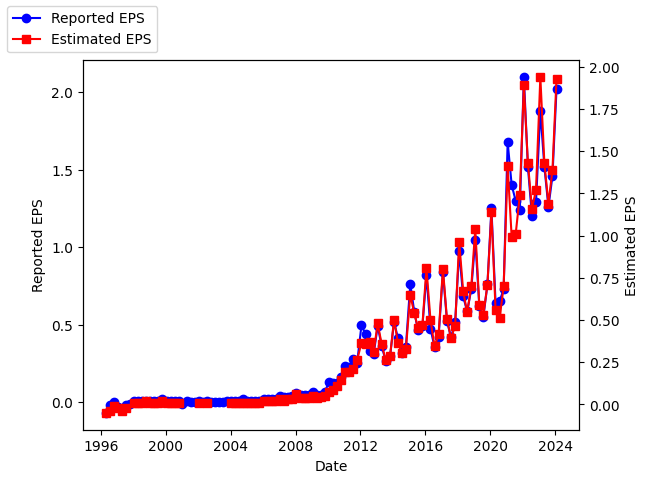

In [6]:
# Plot
fig, ax1 = plt.subplots()

# Plot reportedEPS
ax1.plot(df_eps_plot.index, df_eps_plot['reportedEPS'], color='b', marker='o', label='Reported EPS')
ax1.set_xlabel('Date')
ax1.set_ylabel('Reported EPS')
ax1.tick_params(axis='y')

# Create a twin Axes sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(df_eps_plot.index, df_eps_plot['estimatedEPS'], color='r', marker='s', label='Estimated EPS')
ax2.set_ylabel('Estimated EPS')
ax2.tick_params(axis='y')

fig.legend(loc='upper left');

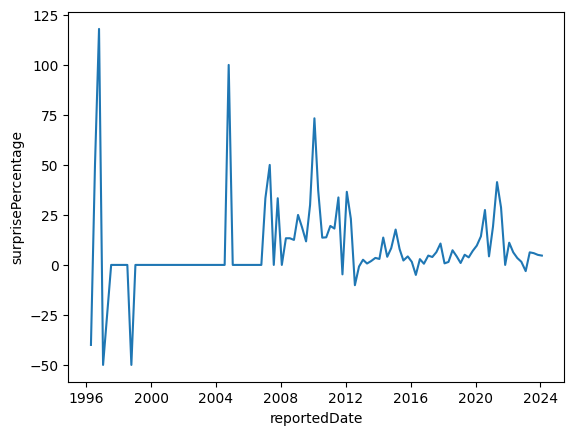

In [7]:
sns.lineplot(data=df['surprisePercentage']);

# Get stock price history

In [8]:
#Stock history from AlphaVantage
sp_data = pd.read_csv('Data/AAPL_price.csv')
sp_data

,Date,Open,High,Low,Adj Close,Volume
0,4/23/2008,5.858929,5.887143,5.752857,4.931376,1504190800
1,4/24/2008,5.905000,6.070714,5.685357,5.114537,1696066400
2,4/25/2008,6.096429,6.110714,5.943571,5.138454,992474000
3,4/28/2008,6.062500,6.205357,6.040357,5.214443,787214400
4,4/29/2008,6.111071,6.273571,6.080357,5.299513,923476400
...,...,...,...,...,...,...
3965,1/24/2024,195.419998,196.380005,194.339996,194.500000,53631300
3966,1/25/2024,195.220001,196.270004,193.110001,194.169998,54822100
3967,1/26/2024,194.270004,194.759995,191.940002,192.419998,44553400
3968,1/29/2024,192.009995,192.199997,189.580002,191.729996,47145600


In [9]:
sp_data.Date = pd.to_datetime(sp_data.Date)
sp_data = sp_data.set_index('Date')
sp_data.rename({'Adj Close': 'Close'}, axis=1, inplace=True)
sp_data


,Open,High,Low,Close,Volume
Date,,,,,
2008-04-23,5.858929,5.887143,5.752857,4.931376,1504190800
2008-04-24,5.905000,6.070714,5.685357,5.114537,1696066400
2008-04-25,6.096429,6.110714,5.943571,5.138454,992474000
2008-04-28,6.062500,6.205357,6.040357,5.214443,787214400
2008-04-29,6.111071,6.273571,6.080357,5.299513,923476400
...,...,...,...,...,...
2024-01-24,195.419998,196.380005,194.339996,194.500000,53631300
2024-01-25,195.220001,196.270004,193.110001,194.169998,54822100
2024-01-26,194.270004,194.759995,191.940002,192.419998,44553400


### Plot stock price and volume history

c:\Users\Scott\Git-Stock\Stock\.venv\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


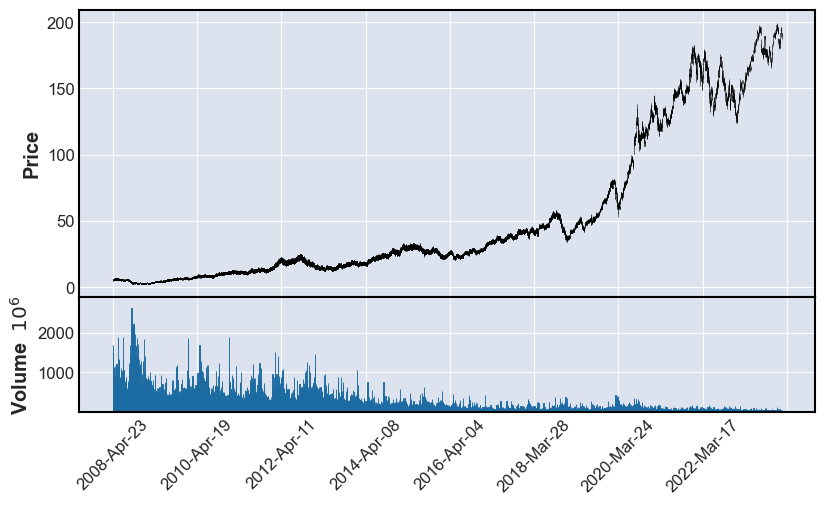

In [10]:
mpf.plot(sp_data, type='candle',volume=True, figratio=(16,9))

## Combine earnings and stock price data

I made the determination to start the stock and EPS data from 01/17/2007 as EPS data reported earlier than that date had too many missing values.

In [2]:
price_earnings = pd.read_csv('Data/AAPL_price_earnings.csv', index_col='Date')
price_earnings

,Unnamed: 0,Open,High,Low,Close,Volume,reportedEPS,estimatedEPS,surprise,surprisePercentage
Date,,,,,,,,,,
2/5/2024,0,188.149994,189.250000,185.839996,187.679993,69668800,2.02,1.93,0.09,4.6632
2/2/2024,1,179.860001,187.330002,179.250000,185.850006,102518000,2.02,1.93,0.09,4.6632
2/1/2024,2,183.990005,186.949997,183.820007,186.860001,64885400,2.02,1.93,0.09,4.6632
1/31/2024,3,187.039993,187.100006,184.350006,184.399994,55467800,1.46,1.39,0.07,5.0360
1/30/2024,4,190.940002,191.800003,187.470001,188.039993,55859400,1.46,1.39,0.07,5.0360
...,...,...,...,...,...,...,...,...,...,...
1/23/2007,4288,3.061786,3.125357,3.053929,2.594505,1207424400,0.04,0.03,0.01,33.3333
1/22/2007,4289,3.183571,3.184286,3.058929,2.627504,1454026000,0.04,0.03,0.01,33.3333
1/19/2007,4290,3.165357,3.201786,3.147143,2.679273,1364473600,0.04,0.03,0.01,33.3333


In [3]:
price_earnings.pop('Unnamed: 0')

Date
2/5/2024        0
2/2/2024        1
2/1/2024        2
1/31/2024       3
1/30/2024       4
             ... 
1/23/2007    4288
1/22/2007    4289
1/19/2007    4290
1/18/2007    4291
1/17/2007    4292
Name: Unnamed: 0, Length: 4293, dtype: int64

In [4]:
#Shifting Close price in Tomorrow column to prevent model knowing the same day closing price, pevents overfitting.
price_earnings['Tomorrow'] = price_earnings['Close'].shift(-1)
price_earnings['Target'] = (price_earnings['Tomorrow'] > price_earnings['Close']).astype(int)
price_earnings

,Open,High,Low,Close,Volume,reportedEPS,estimatedEPS,surprise,surprisePercentage,Tomorrow,Target
Date,,,,,,,,,,,
2/5/2024,188.149994,189.250000,185.839996,187.679993,69668800,2.02,1.93,0.09,4.6632,185.850006,0
2/2/2024,179.860001,187.330002,179.250000,185.850006,102518000,2.02,1.93,0.09,4.6632,186.860001,1
2/1/2024,183.990005,186.949997,183.820007,186.860001,64885400,2.02,1.93,0.09,4.6632,184.399994,0
1/31/2024,187.039993,187.100006,184.350006,184.399994,55467800,1.46,1.39,0.07,5.0360,188.039993,1
1/30/2024,190.940002,191.800003,187.470001,188.039993,55859400,1.46,1.39,0.07,5.0360,191.729996,1
...,...,...,...,...,...,...,...,...,...,...,...
1/23/2007,3.061786,3.125357,3.053929,2.594505,1207424400,0.04,0.03,0.01,33.3333,2.627504,1
1/22/2007,3.183571,3.184286,3.058929,2.627504,1454026000,0.04,0.03,0.01,33.3333,2.679273,1
1/19/2007,3.165357,3.201786,3.147143,2.679273,1364473600,0.04,0.03,0.01,33.3333,2.696529,1


In [77]:
price_earnings['O/C'] = price_earnings['Open'] / price_earnings['Close']
price_earnings['H/C'] = price_earnings['High'] / price_earnings['Close']
price_earnings['L/C'] = price_earnings['Low'] / price_earnings['Close']


In [78]:
price_earnings

,Open,High,Low,Close,Volume,reportedEPS,estimatedEPS,surprise,surprisePercentage,Tomorrow,...,Trend5,Close_Ratio_21,Trend21,Close_Ratio_63,Trend63,Close_Ratio_126,Trend126,O/C,H/C,L/C
Date,,,,,,,,,,,,,,,,,,,,,
2/5/2024,188.125000,189.250000,185.875000,187.625000,69668800,2.019531,1.929688,0.090027,4.664062,185.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.002930,1.008789,0.990723
2/2/2024,179.875000,187.375000,179.250000,185.875000,102518000,2.019531,1.929688,0.090027,4.664062,186.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967773,1.007812,0.964355
2/1/2024,184.000000,187.000000,183.875000,186.875000,64885400,2.019531,1.929688,0.090027,4.664062,184.375000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.984375,1.000977,0.983887
1/31/2024,187.000000,187.125000,184.375000,184.375000,55467800,1.459961,1.389648,0.070007,5.035156,188.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.014648,1.014648,1.000000
1/30/2024,191.000000,191.750000,187.500000,188.000000,55859400,1.459961,1.389648,0.070007,5.035156,191.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.015625,1.019531,0.997559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1/23/2007,3.062500,3.125000,3.054688,2.593750,1207424400,0.040009,0.029999,0.010002,33.343750,2.626953,...,3.0,1.002624,9.0,0.962075,29.0,0.825960,50.0,1.180664,1.205078,1.177734
1/22/2007,3.183594,3.183594,3.058594,2.626953,1454026000,0.040009,0.029999,0.010002,33.343750,2.679688,...,3.0,1.016848,10.0,0.975558,29.0,0.840196,50.0,1.211914,1.211914,1.164062
1/19/2007,3.166016,3.201172,3.146484,2.679688,1364473600,0.040009,0.029999,0.010002,33.343750,2.697266,...,4.0,1.035732,11.0,0.995577,30.0,0.860715,50.0,1.181641,1.194336,1.173828


### (More) Data wrangling

In [5]:
def downcast_cols(price_earnings, cols):
    price_earnings = price_earnings.copy()  # Doesn't modify original DF
    price_earnings[cols] = price_earnings[cols].astype('float16')
    return price_earnings

In [79]:
cols_to_downcast = ['Open', 'High', 'Low', 'Close', 'estimatedEPS',	'surprise', 'surprisePercentage', 'Tomorrow', 'O/C', 'H/C', 'L/C']
price_earnings = downcast_cols(price_earnings, cols_to_downcast)

In [80]:
price_earnings['reportedEPS'] = pd.to_numeric(price_earnings['reportedEPS'], errors='coerce')
price_earnings['reportedEPS'] = price_earnings['reportedEPS'].astype('float16')
price_earnings['Target'] = price_earnings['Target'].astype('int8')

### ML - Random Forest Classifier

In [81]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = price_earnings.iloc[:-500]
test = price_earnings.iloc[-500:]

predictors = ['Open', 'High', 'Low', 'Close', 'Volume', 'reportedEPS',	'estimatedEPS',	'surprise',	'surprisePercentage', 'O/C', 'H/C', 'L/C']
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [82]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [83]:
precision_score(test['Target'], preds) * 100

80.89430894308943

In [84]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

### Backtesting

In [85]:
def backtest(data, model, predictors, start=1250, step=250): 
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [86]:
predictions = backtest(price_earnings, model, predictors)

In [87]:
predictions['Predictions'].value_counts()

Predictions
1    2367
0     676
Name: count, dtype: int64

In [88]:
precision_score(predictions['Target'], predictions['Predictions']) * 100 #Of the prediction 1 above this says that only 52% of the time would the prediction have been correct.

56.40050697084917

In [89]:
predictions['Target'].value_counts() / predictions.shape[0]

Target
0    0.530069
1    0.469931
Name: count, dtype: float64

In [26]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=predictors,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

NameError: name 'export_graphviz' is not defined

### Modified model parameters

In [90]:
horizons = [2,5,21,63, 126] # of rolling averages. # of trading days
new_predictors = []

for horizon in horizons:
    rolling_averages = price_earnings.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    price_earnings[ratio_column] = price_earnings['Close'] / rolling_averages['Close']
    
    trend_column = f"Trend{horizon}" # of days stock price actually went up.
    price_earnings[trend_column] = price_earnings.shift(1).rolling(horizon).sum()['Target']
    
    new_predictors += [ratio_column, trend_column]

In [91]:
price_earnings

,Open,High,Low,Close,Volume,reportedEPS,estimatedEPS,surprise,surprisePercentage,Tomorrow,...,Trend5,Close_Ratio_21,Trend21,Close_Ratio_63,Trend63,Close_Ratio_126,Trend126,O/C,H/C,L/C
Date,,,,,,,,,,,,,,,,,,,,,
2/5/2024,188.125000,189.250000,185.875000,187.625000,69668800,2.019531,1.929688,0.090027,4.664062,185.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.002930,1.008789,0.990723
2/2/2024,179.875000,187.375000,179.250000,185.875000,102518000,2.019531,1.929688,0.090027,4.664062,186.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.967773,1.007812,0.964355
2/1/2024,184.000000,187.000000,183.875000,186.875000,64885400,2.019531,1.929688,0.090027,4.664062,184.375000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.984375,1.000977,0.983887
1/31/2024,187.000000,187.125000,184.375000,184.375000,55467800,1.459961,1.389648,0.070007,5.035156,188.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.014648,1.014648,1.000000
1/30/2024,191.000000,191.750000,187.500000,188.000000,55859400,1.459961,1.389648,0.070007,5.035156,191.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.015625,1.019531,0.997559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1/23/2007,3.062500,3.125000,3.054688,2.593750,1207424400,0.040009,0.029999,0.010002,33.343750,2.626953,...,3.0,1.002624,9.0,0.962075,29.0,0.825960,50.0,1.180664,1.205078,1.177734
1/22/2007,3.183594,3.183594,3.058594,2.626953,1454026000,0.040009,0.029999,0.010002,33.343750,2.679688,...,3.0,1.016848,10.0,0.975558,29.0,0.840196,50.0,1.211914,1.211914,1.164062
1/19/2007,3.166016,3.201172,3.146484,2.679688,1364473600,0.040009,0.029999,0.010002,33.343750,2.697266,...,4.0,1.035732,11.0,0.995577,30.0,0.860715,50.0,1.181641,1.194336,1.173828


In [92]:
#Modified model parameters; originally n_estimators=100, min_samples_split=100
model = RandomForestClassifier(n_estimators=300, min_samples_split=50, random_state=1)

In [93]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:,1] #returns 0 or 1 @ 50%
    preds[preds >= .6] = 1 #raising threshold to 60% vs. default of 50% giving greater probability that a 1.0 is a 1.0.
    preds[preds <= .6] = 0
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [94]:
predictions = backtest(price_earnings, model, new_predictors)

In [95]:
#Predict price going up (1) or down (0) based on 60% threshold
predictions['Predictions'].value_counts()

Predictions
0.0    2846
1.0     197
Name: count, dtype: int64

In [96]:
precision_score(predictions['Target'], predictions['Predictions']) * 100

58.88324873096447

### Adding Randomized Search CV

In [97]:
def predict(train, test, predictors, model):
    # Define the parameter distribution for RandomizedSearchCV
    param_dist = {'n_estimators': randint(50, 500),
                  'max_depth': randint(1, 20)}

    rf = RandomForestClassifier()

    # Use random search to find the best hyperparameters
    rand_search = RandomizedSearchCV(rf,
                                     param_distributions=param_dist,
                                     n_iter=5,
                                     cv=5)

    # Fit random search object to the data
    rand_search.fit(train[predictors], train['Target'])

    # Create a variable for the best model
    best_rf = rand_search.best_estimator_

    print('Best hyperparameters:', rand_search.best_params_)

    # Get the best parameters found by RandomizedSearchCV
    best_params = rand_search.best_params_

    # Update model with the best parameters
    model.set_params(**best_params)

    model.fit(train[predictors], train['Target'])

    # Use the model to make predictions
    preds = model.predict_proba(test[predictors])[:, 1]  # Returns probabilities of class 1
    preds[preds >= .6] = 1  # Raising threshold to 60%
    preds[preds <= .6] = 0
    preds = pd.Series(preds, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], preds], axis=1)
    
    return combined, best_rf

In [98]:
combined_df, best_model = predict(train, test, predictors, model)

Best hyperparameters: {'max_depth': 2, 'n_estimators': 78}


In [99]:
#Predict price going up (1) or down (0) based on 60% threshold
predictions['Predictions'].value_counts()

Predictions
0.0    2846
1.0     197
Name: count, dtype: int64

In [100]:
precision_score(predictions['Target'], predictions['Predictions']) * 100

58.88324873096447

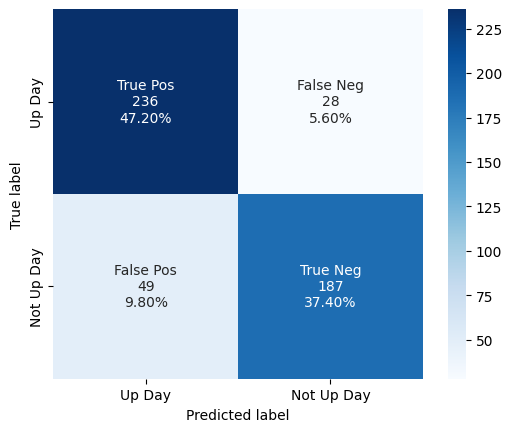

In [101]:
mat = confusion_matrix(combined_df['Target'], combined_df['Predictions'])
group_names = ['True Pos','False Neg','False Pos','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     mat.flatten()/np.sum(mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(mat, square=True, annot=labels, fmt='',cmap='Blues', 
            xticklabels=['Up Day','Not Up Day'],
            yticklabels=['Up Day','Not Up Day'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [102]:
mat = confusion_matrix(combined_df['Target'], combined_df['Predictions'])

accuracy = accuracy_score(combined_df['Target'], combined_df['Predictions'])

precision = precision_score(combined_df['Target'], combined_df['Predictions'])

recall = recall_score(combined_df['Target'], combined_df['Predictions'])

specificity = mat[1, 1] / (mat[1, 0] + mat[1, 1])

f1 = f1_score(combined_df['Target'], combined_df['Predictions'])

print("Accuracy:", accuracy * 100) # Ratio of Total correct instances over total instances.
print("Precision:", precision * 100) # Ratio of true positive predictions to the total number of positive predictions. We minimize how much money we lose with false positives.
print("Recall:", recall * 100) #Ratio of the number of true positive (TP) instances to over all the positive cases. Not as important as precision.
print("Specificity:", specificity * 100) #Measure of how many negative predictions made are correct (true negatives).
print("F1-score:", f1 * 100) # Evaluates the overall performance of a classification model. Range from 0 to 1.

Accuracy: 84.6
Precision: 86.9767441860465
Recall: 79.23728813559322
Specificity: 79.23728813559322
F1-score: 82.92682926829268


## Feature Importance

Due to the randomized feature the **feature importance** will vary each time it's run, which can be very misleading as for what feature(s) is truely important i.e., its importance is only relative to that particular run.

In [103]:
# Create a DataFrame with feature importances
importances = pd.DataFrame({'feature': train[predictors].columns, 'importance': np.round(best_model.feature_importances_, 3)})

# Sort the DataFrame by importance in descending order
importances = importances.sort_values('importance', ascending=False).set_index('feature')

In [104]:
importances.head(10)

,importance
feature,
O/C,0.402
H/C,0.244
L/C,0.134
Close,0.049
Volume,0.041
Open,0.040
reportedEPS,0.033
estimatedEPS,0.019
High,0.016


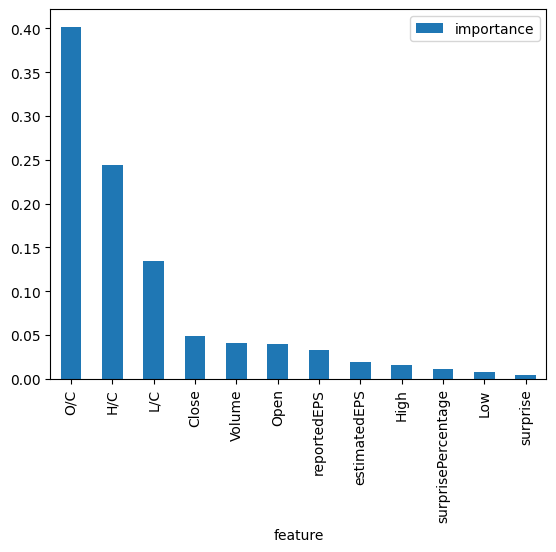

In [105]:
importances.plot.bar();

### Plotting ROC-AUC

Best hyperparameters: {'max_depth': 17, 'n_estimators': 146}


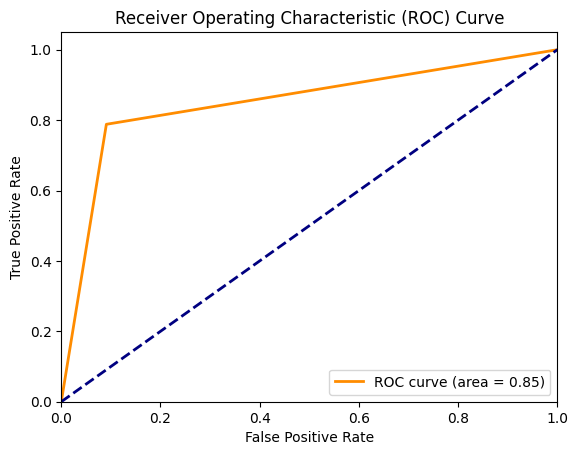

In [106]:
def plot_roc_auc(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = roc_auc_score(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

combined_df, best_model = predict(train, test, predictors, model)

y_true = combined_df['Target']
y_proba = combined_df['Predictions']

plot_roc_auc(y_true, y_proba)

## Using XGBoost

In [118]:
new_predictors = price_earnings[['Close','Volume', 'Open', 'O/C', 'H/C', 'L/C']]
X = new_predictors
y = price_earnings['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=8)

In [119]:
estimators = [
    ('encoder', TargetEncoder()),
    ('clf', XGBClassifier(random_state=8))
]
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

In [120]:

search_space = {
    #'clf__max_depth': (2,8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=5, n_iter=20, scoring='roc_auc', random_state=8)

In [121]:
opt.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                             'clf__gamma': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

### XGBoost Model Evaluation and Predictions

In [122]:
opt.best_estimator_

Pipeline(steps=[('encoder', TargetEncoder(cols=[])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.5, colsample_bynode=1.0,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1.0,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

In [123]:
opt.best_score_ # roc_auc score training set

0.867696042609125

In [124]:
opt.score(X_test,y_test) # roc_auc score test set

0.8775303643724698

In [125]:
opt.predict(X_test)

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

In [126]:
opt.predict_proba(X_test)

array([[0.6980251 , 0.30197492],
       [0.02186728, 0.9781327 ],
       [0.22739393, 0.7726061 ],
       ...,
       [0.04765153, 0.9523485 ],
       [0.9925889 , 0.0074111 ],
       [0.10905367, 0.8909463 ]], dtype=float32)

### XGBoost Feature Importance

In [127]:
opt.best_estimator_.steps

[('encoder', TargetEncoder(cols=[])),
 ('clf',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=0.5, colsample_bynode=1.0, colsample_bytree=1.0,
                device=None, early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=0.0, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=1.0, max_bin=None, max_cat_threshold=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, multi_strategy=None, n_estimators=None,
                n_jobs=None, num_parallel_tree=None, random_state=8, ...))]

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

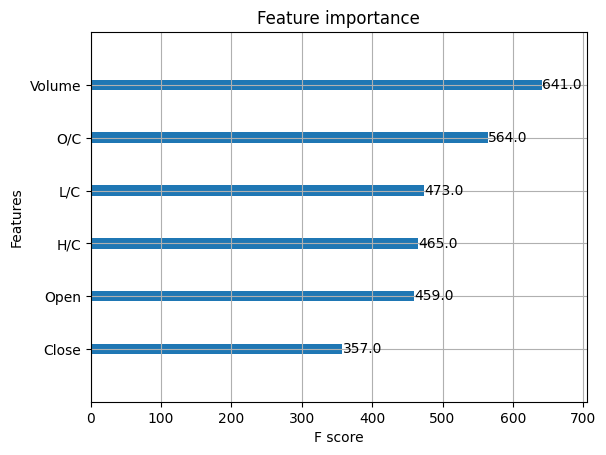

In [128]:
xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

### XGBoost ROC-AUC Curve

ROC-AUC Score: 0.8775303643724698


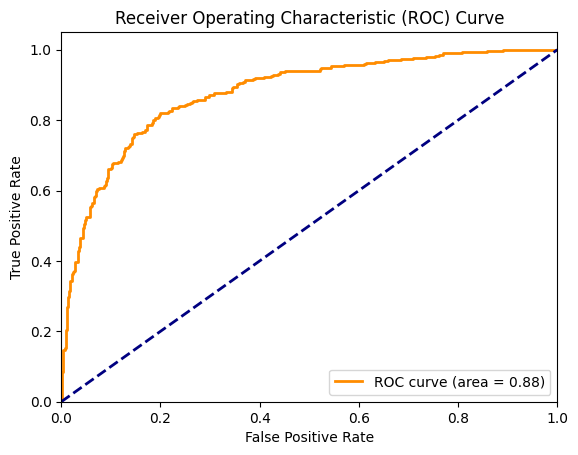

In [129]:
# Fit BayesSearchCV
opt.fit(X_train, y_train)

# Get predicted probabilities on the test set
y_proba = opt.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [38]:
# Save using Joblib
joblib.dump(opt, 'XGB_pipe_model.joblib')

['XGB_pipe_model.joblib']

In [ ]:
# Load using Joblib
loaded_model_joblib = joblib.load('model.joblib')

## Conclusion <a name="Conclusion"></a>

Purpose of this project was to identify Apple stock being either up or down the following day. By using stock price and earnings data we identified with reasonable accuracy the next days price.

Final determination on price direction will require further research. Also, will the addition of more data e.g., news sentiment, help in providing a more accurate score? In addition which ML algorithm is 'best' and which data is

most beneficial.